In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold,StratifiedKFold,ShuffleSplit
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.svm import SVC
import random
#載入所需套件

In [2]:
#載入train.csv，並且分成y(output)和x(input)
df=pd.read_csv('train.csv')
dy=df['Exited']
dx=df[['CreditScore','Geography','Gender','Age','Tenure','Balance','NumOfProducts','HasCrCard','IsActiveMember','EstimatedSalary']]

#使用get_dummies將類別型資料轉成onehot型式
dX=pd.get_dummies(dx,columns=['Geography','Gender'])
feature_names=list(dX.columns)

#將資料標準化
dX_std=StandardScaler().fit_transform(dX)
dX_std[1]
dX.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,720,38,5,114051.97,2,0,1,107577.29,0,0,1,0,1
1,682,54,4,62397.41,1,1,0,113088.60,1,0,0,1,0
2,672,31,5,119903.67,1,1,1,132925.17,1,0,0,1,0
3,592,40,4,104257.86,1,1,0,110857.33,0,0,1,1,0
4,753,42,5,120387.73,1,0,1,126378.57,0,0,1,0,1


In [3]:
#把資料分割成train data, test data
dx_train,dx_test,dy_train,dy_test=train_test_split(dX_std,dy,test_size=0.2,random_state=0)
print(dx_test.shape)
print(dy_test.shape)
print(dx_train.shape)
print(dy_train.shape)

(1600, 13)
(1600,)
(6400, 13)
(6400,)


In [4]:
#分割資料，將資料分成3份，以便使用Cross-Validation的方法進行驗證
cv=StratifiedKFold(n_splits=3)

test_acc_scores=[]
test_precision_scores=[]
test_f1_scores=[]
test_final_scores=[]
para=[]
cv_acc_scores=[]
cv_precision_scores=[]
cv_f1_scores=[]
cv_final_scores=[]

In [5]:
#由於SVM的超參數過多，除了非隨機(自訂)的超參數之外，這邊也使用隨機選取的方法試試看能不能找出更好的超參數
C=np.linspace(1,100,100)
gamma=np.linspace(0.01,1,100)
select=np.random.randint(0, 100,size=4)
select2=np.random.randint(0, 100,size=4)
print(select)
print(select2)

[53  4 11 50]
[40 74  8 67]


In [6]:
#隨機選出來的超參數
C_para=C[select]
gamma_para=gamma[select2]
print(C_para)
print(gamma_para)

[54.  5. 12. 51.]
[0.41 0.75 0.09 0.68]


In [7]:
#此處為非隨機(自訂)的超參數
C_para=[50,100,150]
gamma_para=[0.01,0.05,0.1]
kernel_para=['rbf']

#for迴圈用來檢驗超參數，並使用兩種檢驗方法，一種是單純將資料分成train和test，另一種則是使用交叉驗證法
#分別計算兩種檢驗方法的accuracy, precision, f1_score，並且使用網站給定的三種權重(0.3*accuracy+0.4*precision+0.4*f1_score)算出
#兩種檢驗方法下的各個不同超參數的final_score

for c in C_para:
    for g in gamma_para:
        for k in kernel_para:
            model=SVC(C=c,gamma=g,kernel=k)
            model.fit(dx_train,dy_train)
            predictions=model.predict(dx_test)
    
            test_acc_scores.append(model.score(dx_test,dy_test))
    
            precision=precision_score(dy_test, predictions)
            recall=recall_score(dy_test, predictions)
            f1_score=(2*precision*recall)/(precision+recall)
    
            test_precision_scores.append(precision)
            test_f1_scores.append(f1_score)
            test_final_scores.append(0.3*model.score(dx_test,dy_test)+0.4*precision+0.4*f1_score)
    
            para.append([c,g,k])    #每次跑完後記錄一次所使用的超參數，方便查找
            print(c,g,k)
    
            acc_sum=0
            precision_sum=0
            f1_sum=0
            final_score=0
            for train_index,test_index in cv.split(dx_train,dy_train):
                x_train=dx_train[train_index]
                x_test=dx_train[test_index]
                y_train=dy_train.iloc[train_index]
                y_test=dy_train.iloc[test_index]
        
                model.fit(x_train,y_train)
                predictions2=model.predict(x_test)
                acc_sum=acc_sum+model.score(x_test,y_test)
        
                precision2=precision_score(y_test, predictions2)
                recall2=recall_score(y_test, predictions2)
                f1_score2=(2*precision2*recall2)/(precision2+recall2)
        
                precision_sum=precision_sum+precision2
                f1_sum=f1_sum+f1_score2
                final_score=final_score+0.3*model.score(x_test,y_test)+0.4*precision2+0.4*f1_score2
    
            cv_acc_scores.append(acc_sum/3)
            cv_precision_scores.append(precision_sum/3)
            cv_f1_scores.append(f1_sum/3)
            cv_final_scores.append(final_score/3)

50 0.01 rbf
50 0.05 rbf
50 0.1 rbf
100 0.01 rbf
100 0.05 rbf
100 0.1 rbf
150 0.01 rbf
150 0.05 rbf
150 0.1 rbf


In [8]:
#將結果放入Dataframe(此處為test_train分割的結果)，其中para是每次驗證所使用的超參數
test_score=pd.DataFrame({
    'acc':test_acc_scores,
    'precision':test_precision_scores,
    'f1':test_f1_scores,
    'final_score':test_final_scores,
    'para':para
})
test_score

,acc,precision,f1,final_score,para
0,0.855625,0.851064,0.509554,0.800935,"[50, 0.01, rbf]"
1,0.851875,0.729064,0.555347,0.769327,"[50, 0.05, rbf]"
2,0.830000,0.623932,0.517730,0.705665,"[50, 0.1, rbf]"
3,0.856875,0.848276,0.517895,0.803531,"[100, 0.01, rbf]"
4,0.846250,0.700000,0.544444,0.751653,"[100, 0.05, rbf]"
5,0.811250,0.553435,0.489865,0.660695,"[100, 0.1, rbf]"
6,0.856875,0.838926,0.521921,0.801401,"[150, 0.01, rbf]"
7,0.846250,0.696262,0.547794,0.751497,"[150, 0.05, rbf]"
8,0.799375,0.516129,0.472906,0.635427,"[150, 0.1, rbf]"


In [9]:
#將結果放入Dataframe(此處為CV的結果)，其中para是每次驗證所使用的超參數
cv_score=pd.DataFrame({
    'acc':cv_acc_scores,
    'precision':cv_precision_scores,
    'f1':cv_f1_scores,
    'final_score':cv_final_scores,
    'para':para
})
cv_score

,acc,precision,f1,final_score,para
0,0.854688,0.811290,0.511056,0.785345,"[50, 0.01, rbf]"
1,0.844063,0.678069,0.537419,0.739414,"[50, 0.05, rbf]"
2,0.824688,0.585273,0.523595,0.690953,"[50, 0.1, rbf]"
3,0.855001,0.803551,0.517230,0.784813,"[100, 0.01, rbf]"
4,0.839376,0.650153,0.534763,0.725779,"[100, 0.05, rbf]"
5,0.815939,0.553240,0.520942,0.674455,"[100, 0.1, rbf]"
6,0.855157,0.796100,0.522390,0.783943,"[150, 0.01, rbf]"
7,0.834844,0.627339,0.532809,0.714512,"[150, 0.05, rbf]"
8,0.808127,0.530006,0.512058,0.659264,"[150, 0.1, rbf]"


In [10]:
x=[i for i in range(len(cv_score))]

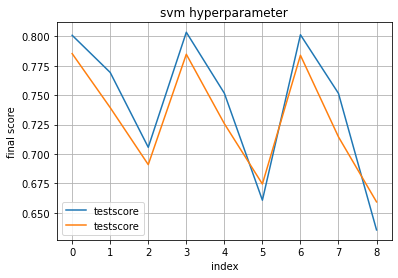

In [11]:
#劃出圖表，並以目測的方式找出各個出現峰值的超參數點，並將所有出現峰值的點的超參數都拿來train一次並將結果上傳網站
plt.title('svm hyperparameter')
plt.plot(x,test_score['final_score'],label='testscore')
plt.plot(x,cv_score['final_score'],label='testscore')
plt.xlabel('index')
plt.ylabel('final score')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
#載入測試資料並且標準化
df_test=pd.read_csv('test.csv')
dx2=df_test[['CreditScore','Geography','Gender','Age','Tenure','Balance','NumOfProducts','HasCrCard','IsActiveMember','EstimatedSalary']]
dx_test2=pd.get_dummies(dx2,columns=['Geography','Gender'])
dx_test_std2=StandardScaler().fit_transform(dx_test2)

In [13]:
#紀錄每次上傳自網站的超參數的結果
nonlinear_svm=SVC(C=100,gamma=0.01,kernel='rbf') #16
nonlinear_svm.fit(dx_train,dy_train)
prediction_svm=nonlinear_svm.predict(dx_test_std2)
df_svm_out=pd.DataFrame({
    "RowNumber":df_test['RowNumber'],
    "Exited":prediction_svm
})
df_svm_out.to_csv('svm_sample2.csv')
#acc: 0.8750
#precision: 0.8049
#fScore: 0.5690

In [14]:
#紀錄每次上傳自網站的超參數的結果
nonlinear_svm=SVC(C=150,gamma=0.01,kernel='rbf') 
nonlinear_svm.fit(dx_train,dy_train)
prediction_svm=nonlinear_svm.predict(dx_test_std2)
df_svm_out=pd.DataFrame({
    "RowNumber":df_test['RowNumber'],
    "Exited":prediction_svm
})
df_svm_out.to_csv('svm_sample2.csv')
#acc: 0.8650
#precision: 0.7234
#fScore: 0.5574